In [1]:
import networkx as nx
from networkx.algorithms import community # ~louvain
import community as community_louvain

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Fonts for plots
#mpl.rcParams['font.serif'] = 'Times New Roman'
#plt.rcParams['font.family'] = 'serif'

pd.set_option('display.max_columns', None)

# Path to data retrieval and storage
path = "C:/Users/kleinow/ownCloud/MA_Neuro"

In [2]:
authors = pd.read_csv(path + "/cn_authors_clean.csv")
len(authors) #32479

32479

In [3]:
authors.head()

,item_id,author_seq_nr,given_name,family_name,corresponding,aff_seq_nr,organization,wos_suborganization,vendor_org_id,family_name_lower_wo_space,given_name_lower_wo_space,name,suborga_modified,country,city,pubyear
0,WOS:000075569500101,1,JL,Krichmar,True,NaN,NaN,NaN,NaN,krichmar,jl,krichmar_jeffreyl,"{""Dept Cognit Sci""}",USA,Fairfax,1998
1,WOS:000075569500101,2,GA,Ascoli,False,NaN,NaN,NaN,NaN,ascoli,ga,ascoli_giorgioa,"{""Krasnow Inst Adv Study""}",USA,Fairfax,1998
2,WOS:000075569500101,3,JL,Olds,False,NaN,NaN,NaN,NaN,olds,jl,olds_jamesleland,"{""Schar Sch Publ Policy""}",USA,Fairfax,1998
3,WOS:000075569500101,4,L,Hunter,False,NaN,NaN,NaN,NaN,hunter,l,hunter_l,NaN,USA,Fairfax,1998
4,WOS:000086279300008,1,J,Bickle,True,NaN,NaN,NaN,NaN,bickle,j,bickle_j,NaN,USA,Greenville,2000


Basic information about the authors dataset

In [4]:
total_entries = len(authors)


unique_authors = authors['name'].nunique(dropna=True)  # dropna=True to exclude NaN values
unique_publications = authors['item_id'].nunique(dropna=True)

earliest_year = authors['pubyear'].min()
latest_year = authors['pubyear'].max()
unique_departments = authors['suborga_modified'].nunique(dropna=True)  # dropna=True to exclude NaN values

# Add this to the summary DataFrame
summary_df = pd.DataFrame({
    'Metric': ['Total Entries', 'Unique Authors', 'Unique Publications', 'Unique Departments', 'Earliest Pub. Year', 'Latest Pub. Year'],
    'Value': [total_entries, unique_authors, unique_publications, unique_departments, earliest_year, latest_year]
})


summary_df

,Metric,Value
0,Total Entries,32479
1,Unique Authors,4161
2,Unique Publications,1553
3,Unique Departments,1935
4,Earliest Pub. Year,1991
5,Latest Pub. Year,2023


In [5]:
top_10_departments = authors['suborga_modified'].value_counts().head(10)

# Convert to DataFrame for better visualization
top_10_departments_df = pd.DataFrame({
    'Department': top_10_departments.index,
    'Frequency': top_10_departments.values
})

top_10_departments_df

,Department,Frequency
0,"{""Dept Neurol""}",855
1,"{""Inst Neurosci & Med INM 6""}",514
2,"{""Dept Comp Sci""}",513
3,"{""Dept Psychol""}",471
4,"{""Translat Neuromodeling Unit TNU"",""Inst Biome...",420
5,"{""Inst Adv Simulat IAS 6""}",404
6,"{""Dept Psychiat""}",354
7,"{""Dept Neurosci""}",353
8,"{""Dept Biomed Engn""}",285
9,"{""Dept Neurosci Physiol & Pharmacol""}",268


Graph

In [6]:
G_Collabnet = nx.Graph() # Create empty graph

In [7]:
# Add edges to graph
for item in authors['item_id'].unique():
    # Get all authors of this publication but exclude NaNs
    authors_list = authors[authors['item_id'] == item]['name'].dropna().tolist()

    # Explicitly add nodes while excluding NaNs (This step is optional? Nodes as item_id_clear should be added automatically)
    for author in authors_list:
        G_Collabnet.add_node(author)
        
    # Create an edge for every pair of authors
    for i in range(len(authors_list)):
        for j in range(i+1, len(authors_list)):
            # If the edge already exists, increment its weight by 1
            if G_Collabnet.has_edge(authors_list[i], authors_list[j]):
                G_Collabnet[authors_list[i]][authors_list[j]]['weight'] += 1
            # Else, create a new edge with weight 1
            else:
                G_Collabnet.add_edge(authors_list[i], authors_list[j], weight=1)

In [8]:
# Save Network to GEXF file
nx.write_gexf(G_Collabnet, "G_Collabnet.gexf")

Analysis of the author collaboration network

Network metrics

Comparison of the whole authors data and the data from 2005 onwards

In [9]:
# Subset of authors dataframe
authors_young = authors[authors['pubyear'] >= 2010]

In [10]:
# Create graph for younger collaboration network
G_Collabnet_young = nx.Graph()

# Add edges to graph (Same code as before but for the filtered dataframe)
for item in authors_young['item_id'].unique():
    authors_list = authors_young[authors_young['item_id'] == item]['name'].dropna().tolist()
    for i in range(len(authors_list)):
        for j in range(i+1, len(authors_list)):
            if G_Collabnet_young.has_edge(authors_list[i], authors_list[j]):
                G_Collabnet_young[authors_list[i]][authors_list[j]]['weight'] += 1
            else:
                G_Collabnet_young.add_edge(authors_list[i], authors_list[j], weight=1)

In [11]:
# Function to calculate networks metrics
def calculate_metrics(G):
    metrics = {}
    # Basic metrics
    metrics['# Nodes'] = G.number_of_nodes()
    metrics['# Edges'] = G.number_of_edges()
    metrics['# Isolated nodes'] = len(list(nx.isolates(G))) # Isolated nodes have no edges, so an author who has not collaborated with anyone else!
    metrics['% Isolated nodes'] = (metrics['# Isolated nodes'] / metrics['# Nodes']) * 100 if metrics['# Nodes'] != 0 else 0 # added if statement to avoid division by zero
    
    #Advanced metrics
    metrics['# Connected components'] = nx.number_connected_components(G)
    metrics['Size of largest components'] = len(max(nx.connected_components(G), key=len))
    metrics['Av. degree'] = sum(dict(G.degree()).values()) / metrics['# Nodes']
    metrics['# Communities'] = len(community.greedy_modularity_communities(G))

    partition = community_louvain.best_partition(G)     # Compute best partition of graph nodes for modularity
    metrics['Modularity'] = community_louvain.modularity(partition, G)
    
    metrics['Clustering Coefficient'] = nx.average_clustering(G)


    return metrics


In [12]:

# Metrics for both graphs
metrics_original = calculate_metrics(G_Collabnet)
metrics_young = calculate_metrics(G_Collabnet_young)

#Df with metrics side-by-side
df_metrics = pd.DataFrame({'Metric': list(metrics_original.keys()),
                           'G': list(metrics_original.values()),
                           'G after 2010': list(metrics_young.values())})


In [13]:
df_metrics

,Metric,G,G after 2010
0,# Nodes,4161.000000,3466.000000
1,# Edges,15703.000000,14031.000000
2,# Isolated nodes,105.000000,0.000000
3,% Isolated nodes,2.523432,0.000000
4,# Connected components,759.000000,564.000000
5,Size of largest components,1015.000000,815.000000
6,Av. degree,7.547705,8.096365
7,# Communities,784.000000,581.000000
8,Modularity,0.870108,0.864644
9,Clustering Coefficient,0.806957,0.844340


In [14]:
from lib.crisp_partition import leiden as leiden_seed
coms = leiden_seed(G_Collabnet, weights='weight')
coms_young = leiden_seed(G_Collabnet_young, weights='weight')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'karateclub', 'wurlitzer', 'graph_tool'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'karateclub', 'wurlitzer', 'graph_tool'}


Assess central authors by centrality measures

Note: For the centrality measures to work, the graph must be connected, which means there must be a series of edges that connets every node to any other node. In this case, the full graph is not connected. But NetworkX should handle isolated nodes appropriately and assign them a centrality of zero. 

In [15]:
# Function to calculate the top 10 authors by centrality
def top_10_central(G, centrality_type):
    """
    Function to calculate the top 10 most central authors in given network graph.

    Parameters:
    G (Graph): The network graph
    centrality_type (str): The type of centrality to calculate ('betweenness' or 'closeness')

    Returns:
    list: Sorted list of tuples with the top 10 authors and their centrality score
    """
    if centrality_type == 'betweenness': # Check type of centrality metric to calculate
        centrality_dict = nx.betweenness_centrality(G) # Betweenness ...
    elif centrality_type == 'closeness':
        centrality_dict = nx.closeness_centrality(G) # Closeness ...
    else:
        return "Invalid centrality type" # added this to avoid errors
        
    sorted_centrality = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:10]
    return sorted_centrality

# Calculate top 10 central nodes based on betweenness centrality for both graphs
top_10_betweenness_original = top_10_central(G_Collabnet, 'betweenness')
top_10_betweenness_young = top_10_central(G_Collabnet_young, 'betweenness')

# Calculate top 10 central nodes based on closeness centrality for both graphs
top_10_closeness_original = top_10_central(G_Collabnet, 'closeness')
top_10_closeness_young = top_10_central(G_Collabnet_young, 'closeness')

# Combine all these into a DataFrame for easier comparison
df_top_10_centralities = pd.DataFrame({
    'Top 10 Betweenness - Original': [f"{x[0]} ({x[1]:.3f})" for x in top_10_betweenness_original], # .3f means 3 decimal places
    'Top 10 Betweenness - Young': [f"{x[0]} ({x[1]:.3f})" for x in top_10_betweenness_young],
    'Top 10 Closeness - Original': [f"{x[0]} ({x[1]:.3f})" for x in top_10_closeness_original],
    'Top 10 Closeness - Young': [f"{x[0]} ({x[1]:.3f})" for x in top_10_closeness_young]
})



REMEMBER TO ADD FUNCTION DESCRIPIONS TO OTHER FUNCTIONS

In [16]:
df_top_10_centralities

,Top 10 Betweenness - Original,Top 10 Betweenness - Young,Top 10 Closeness - Original,Top 10 Closeness - Young
0,maass_wolfgang (0.020),maass_wolfgang (0.018),morrison_abigail (0.061),morrison_abigail (0.061)
1,logothetis_nikosk (0.020),logothetis_nikosk (0.018),davison_andrewp (0.059),davison_andrewp (0.060)
2,deco_gustavo (0.019),deco_gustavo (0.017),diesmann_markus (0.059),diesmann_markus (0.059)
3,jirsa_viktork (0.016),jirsa_viktork (0.015),mueller_eric (0.058),mueller_eric (0.058)
4,diesmann_markus (0.014),diesmann_markus (0.013),eppler_jochenmartin (0.058),eppler_jochenmartin (0.058)
5,subramoney_anand (0.014),subramoney_anand (0.013),muller_eilif (0.057),schemmel_johannes (0.058)
6,breakspear_michael (0.012),morrison_abigail (0.010),schemmel_johannes (0.057),petrovici_mihaia (0.057)
7,friston_karlj (0.011),breakspear_michael (0.010),petrovici_mihaia (0.057),meier_karlheinz (0.057)
8,morrison_abigail (0.011),friston_karlj (0.010),meier_karlheinz (0.057),diazpier_sandra (0.057)
9,hines_michaell (0.009),hines_michaell (0.009),diazpier_sandra (0.057),hopkins_michaelw (0.057)


Nodes of different clusters in both networks

In [17]:

partition_original = community_louvain.best_partition(G_Collabnet)

partition_young = community_louvain.best_partition(G_Collabnet_young)

# Function to extract communities
def extract_communities(partition):
    """
    Function ...

    Parameters:

    Returns:

    """
    communities = {}
    for node, community_id in partition.items():
        if community_id not in communities:
            communities[community_id] = []
        communities[community_id].append(node)
    return communities

# Extract communities for both graphs
communities_original = extract_communities(partition_original)
communities_young = extract_communities(partition_young)

# to dataframe
def communities_to_df(communities):
    """
    Function ...

    Parameters:

    Returns:
    
    """
    data = []
    for community_id, nodes in communities.items():
        for node in nodes:
            data.append({'Community_ID': community_id, 'Node': node})
    return pd.DataFrame(data)

df_communities_original = communities_to_df(communities_original)
df_communities_young = communities_to_df(communities_young)

# Save to CSV
df_communities_original.to_csv('communities_original.csv', index=False)
df_communities_young.to_csv('communities_young.csv', index=False)

df_communities_original

,Community_ID,Node
0,0,krichmar_jeffreyl
1,0,olds_jamesleland
2,0,hunter_l
3,0,zaldivar_andrew
4,0,asher_derrike
...,...,...
4156,133,bankes_sc
4157,133,margoliash_d
4158,557,somers_dc
4159,557,nelson_sb


In [18]:
df_communities_young

,Community_ID,Node
0,0,bland_amyr
1,0,schaefer_alexandre
2,1,thornton_john
3,1,srbic_andrew
4,1,main_linda
...,...,...
3461,4,gao_chenghua
3462,235,psarellis_yorgosmm
3463,235,kavousanakis_michail
3464,235,henson_michaelaa


In [19]:
# Number of communities in the original network
num_communities_original = len(set(partition_original.values()))

# Number of communities in the young network
num_communities_young = len(set(partition_young.values()))

print(f"Number of communities in the original network: {num_communities_original}")
print(f"Number of communities in the young network: {num_communities_young}")


Number of communities in the original network: 791
Number of communities in the young network: 587


Triadic Closures due to Collaboration

In [20]:
# Dictionary to map author pairs to years in which they collaborated
collaborations = {}

# Dictionary to map author to their collaborations in a specific year
author_to_collaborations = {}

for index, row in authors.iterrows(): # Loop through all rows in the dataframe
    author = row['name'] # Get author name
    year = row['pubyear'] # Get publication year
    item = row['item_id'] # Get item id
    
    if not isinstance(author, str):
        continue  # Skip row if 'name' is not a string to avoid errors because of NaN values
    
    # List of all co-authors for current item, excluding NaNs
    coauthors = authors[authors['item_id'] == item]['name'].dropna().tolist()  # drop NaN values
    if author in coauthors: 
        coauthors.remove(author) # remove the current author from co-authors list
    
    if not coauthors:  # Skip row if there are no co-authors
        continue
    
    if author not in author_to_collaborations: # If author is not in the dictionary, add him
        author_to_collaborations[author] = {} # Create a new dictionary for the author
    author_to_collaborations[author][year] = coauthors  # update current authors collaborations for the current year

    for coauthor in coauthors: # Update collaborations dictionary
        pair = tuple(sorted([author, coauthor])) # Sort the pair of authors in order to avoid duplicates like AB and BA
        if pair not in collaborations: # if not already present, initialize the year pair's list
            collaborations[pair] = [] # Create a new list for the pair
        collaborations[pair].append(year) # Add the current year to the list of years in which the pair collaborated




# Triadic closure checking
triadic_closures = [] # List to store triadic closures

for (A, B), years in collaborations.items(): # Loop through all pairs of authors in collaboration dictionary
    last_collab_year = max(years) # Get the last year in which A and B collaborated

    # Check for other collaborations of B without A after last_collab_year
    for year, collabs_of_B in author_to_collaborations.get(B, {}).items(): # check if B had collaborations with other authors after last_collab_year with A
        if year <= last_collab_year: 
            continue # conitnue if year is before last_collab_year
        if A not in collabs_of_B: 

            for C in collabs_of_B: # Check if A collaborated with those authors in years > year aka the future
                # Check if A and C collaborated in years > year
                pair = tuple(sorted([A, C])) # create a tuple pair of A and C
                if pair in collaborations and any(y > year for y in collaborations[pair]): # Check if A and C collaborated in years > year which is B' collab with C
                    triadic_closures.append((A, B, C)) # Add triadic closure to list

print(f"Triadic closures: {len(triadic_closures)}") # 1716 triadic closures

Triadic closures: 1716


Clustering Coefficient

In [21]:
avg_clustering_coefficient = nx.average_clustering(G_Collabnet, weight='weight')
avg_clustering_coefficient


0.004425628808387083

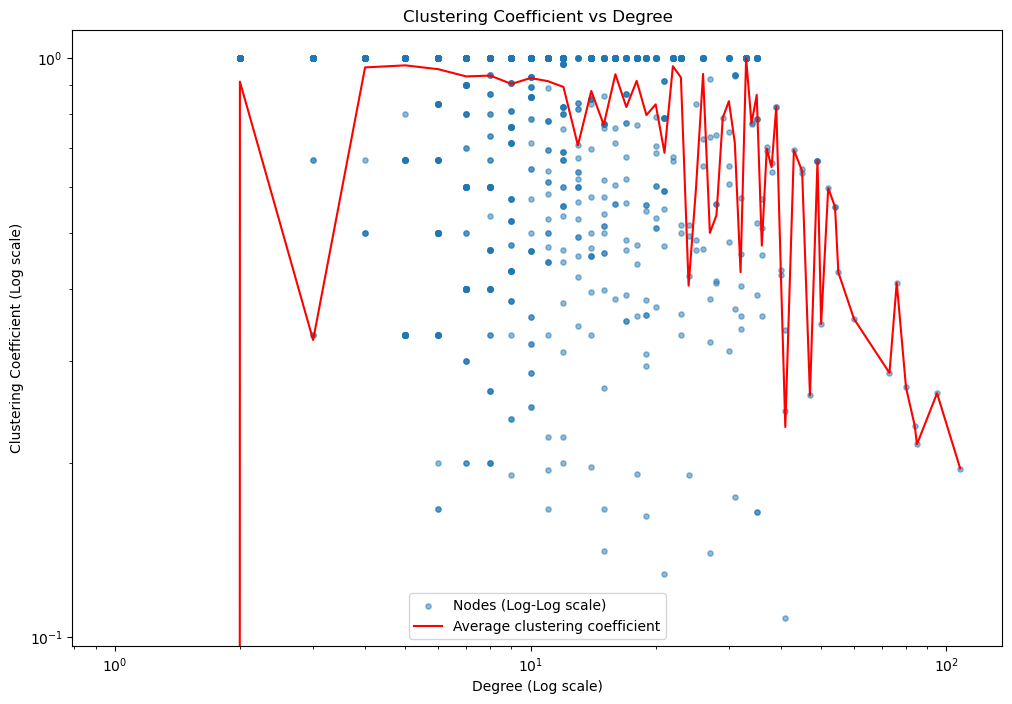

In [22]:
G = G_Collabnet  # Replace with your network

# Get degree and local clustering coefficient for each node
degrees = [degree for node, degree in G.degree()]
coeffs = [nx.clustering(G, node) for node in G.nodes()]

# Compute the average local clustering coefficient for each degree
avg_coeffs = {}
for degree, coeff in zip(degrees, coeffs):
    if degree not in avg_coeffs:
        avg_coeffs[degree] = []
    avg_coeffs[degree].append(coeff)

# Prepare data for the red line
avg_degree = sorted(list(avg_coeffs.keys()))
avg_coeff = [np.mean(avg_coeffs[deg]) for deg in avg_degree]

# Plot data
plt.figure(figsize=(12, 8))
plt.scatter(degrees, coeffs, alpha=0.5, s=14, label='Nodes (Log-Log scale)')
plt.plot(avg_degree, avg_coeff, 'r-', label='Average clustering coefficient')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (Log scale)')
plt.ylabel('Clustering Coefficient (Log scale)')
plt.legend()
plt.title('Clustering Coefficient vs Degree')
plt.show()